
# Creating Patterns with Bouncing Balls

After watching a YouTube Short, I became intrigued by the idea of simulating motion physics and creating patterns in Python. Driven by this new interest, I tried to learn underlying principles using reddit and my understandings are explained below. 

But first, let's look at the original youtube short.



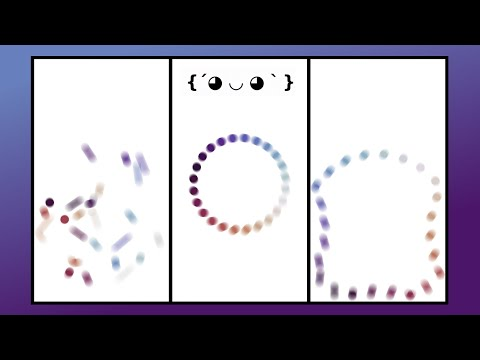

In [44]:

from IPython.display import YouTubeVideo
YouTubeVideo('d7UpLz27Q9Y')

Initial Observations:

At first glance, the animation presents a captivating display where:

Randomly generated balls come to the frame.
These balls adhere to the laws of physics, bouncing within a confined space and interacting with each other.
Eventually, they form a distinct pattern before gradually dispersing.

Behind the Scenes:

However, the true mechanism behind each animation is a blend of two distinct simulations, both initiating from the same arrangement of balls (t = 0):

Forward Simulation: This progresses from the initial point to two seconds later (t = 0 to t = +2), where the balls move according to standard physics.
Backward Simulation: This runs from the same starting point but in reverse, going back two seconds (t = 0 to t = -2).
Creating the backward simulation involves a couple of clever tweaks:

Reversing Initial Velocity: The balls are set off with their velocities directed opposite to the forward simulation.
Altering Elasticity: Typically, balls lose a fraction of energy (about 10% with an elasticity of 0.9) with each bounce. In this simulation, we invert this rule - the balls gain energy upon each impact (adjusting elasticity to roughly 1.1, or 1 / 0.9).
Convergence to Reality:

When this backward simulation is reversed for playback, an intriguing phenomenon unfolds. It mirrors the forward simulation - the balls now lose energy with each bounce, aligning with expected physical behavior. They ultimately converge back to the initial, neatly arranged pattern defined at t = 0, closing the loop of this fascinating animation journey.

This process is explained significantly better here by the original animator: https://nbviewer.org/github/alessandro-giusti/bouncing-ball-patterns/blob/main/bouncing.ipynb

In [45]:
import pymunk
from pymunk.vec2d import Vec2d
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation

def setup_space(width, height, e):
    # Initialize the physical space
    space = pymunk.Space()
    space.gravity = 0, -9.820  # Setting gravity
    space.damping = 0.9999  # Applying damping to reduce energy over time

    # static elements in the boundary (walls)
    static_body = space.static_body
    gap = 0.1
    static_lines = [
        pymunk.Segment(static_body, (gap, gap), (width - gap, gap), 0.01),  # Bottom edge
        pymunk.Segment(static_body, (width - gap, gap), (width - gap, height * 100), 0.01),  # Right edge
        pymunk.Segment(static_body, (gap, gap), (gap, height * 100), 0.01),  # Left edge
    ]
    
    # Setting elasticity for each boundary line
    for line in static_lines:
        line.elasticity = e
        line.friction = 0
    space.add(*static_lines)
    return space

def create_ball(x, y, vx, vy, radius, e, space):
    # Create and configure a new ball
    ball = pymunk.Body(0, 0)
    ball.position = Vec2d(x, y)
    ball.velocity = Vec2d(vx, vy)
    shape = pymunk.Circle(ball, radius)
    shape.density = 1
    shape.elasticity = e
    space.add(ball, shape)
    return ball


The initialize functionbelow is designed to set up a simulation for animating balls that form specific letters. It begins by defining the dimensions and elasticity of the simulation area. Then, it specifies the radius for each ball to be used in the animation. The core of the function involves calculating the positions of these balls so that they collectively form the shapes of letters. In this case, the letters formed are 'B', 'A', 'L', and 'L'. The function achieves this by creating a series of coordinates for each point where a ball should be placed to outline the letters. These coordinates are calculated based on predefined starting positions and spacing. Once the points are established, the function creates balls at each of these positions within the simulation space. The function ultimately returns the dimensions of the simulation area, the simulation space, and the collection of balls, setting the stage for the animation of these letter.

In [46]:
def initialize():
    width, height = 16, 9
    e = 0.90  # Elasticity
    space = setup_space(width, height, e)
    
    r = 0.2  # Radius of each ball
    balls = []

    # Letter spacing and line thickness
    spacing = 1.0
    line_thickness = 0.1

    # Starting positions for each letter
    start_x_B = 1
    start_x_A = start_x_B + 3 + spacing
    start_x_L = start_x_A + 3 + spacing
    start_x_Li = start_x_L + 3 + spacing

    letter_points= []
    #points for 'B'
    letter_points += [(start_x_B, y*0.25) for y in range(12,36)]#left-stick
    #top
    letter_points += [(start_x_B+ x*0.25, 9) for x in range(8)]
    #middle
    letter_points += [(start_x_B+ x* 0.25, 6) for x in range(8)]
    #bottom
    letter_points += [(start_x_B+x*0.25, 3 ) for x in range(8)]
    #right-stick
    letter_points += [(start_x_B + 2, y*0.25) for y in range(12,36)]#left-stick

    #letter_points = [(1, 4), (1, 5), (1, 6), (1, 7), (2, 8), (3, 8), (4, 7), (4, 6), (3, 5), (2, 5) ,(3, 4) ,(4, 3) ,(4, 2), (3, 1), (2, 1), (1, 2)]
    
    # Points for 'A'
    
    # Adjusted points for 'A' with more balls
    letter_points += [(start_x_A + x * 0.5, 9) for x in range(5)]  # Top with denser points
    letter_points += [(start_x_A, y*0.5) for y in range(6,24)]  # Left with denser points
    letter_points += [(start_x_A + 2, y*0.5) for y in range(6,24)]  # Right with denser points
    letter_points += [(start_x_A + x * 0.5, 5) for x in range(5)]  # Middle with denser points

    
    #points for 'l'
    
    letter_points+= [(start_x_L, y*0.25) for y in range(12,36)]
    letter_points+= [(start_x_L+x*0.25, 3) for x in range(10)]
    
    letter_points+= [(start_x_Li, y*0.25) for y in range(12,36)]
    letter_points+= [(start_x_Li+x*0.25, 3) for x in range(10)]


    # Create balls at the letter points
    for point in letter_points:
        x, y = point
        balls.append(mk_ball(x, y, 0, 0, r, e, space))

    return width, height, space, balls


At each step, the simulate function records the positions of all the balls, tracking their trajectories. The simulation is mindful of a set height limit, removing any ball that surpasses this threshold. This function is versatile, being employed twice: first, to simulate the forward motion of balls with standard physical properties, and second, for a backward simulation where initial velocities and elasticity are inverted. This dual application enables the creation of our animation sequence that first follows the natural physics of motion and then reverses it. The results from both simulations are combined to produce ball positions over time.

In [48]:
def simulate_motion(simulation_space, balls, duration, timestep, height_limit):
    # Run the simulation for a given duration with specified timestep
    time_stamps = np.arange(0, duration, timestep)
    positions = []

    for t in time_stamps:
        # Record positions of each ball
        positions.append([np.array(ball.position) for ball in balls])

        # Update the simulation by one timestep
        simulation_space.step(timestep)

        # Remove balls that move out of the specified height limit
    for ball in balls:
        shape = next(iter(ball.shapes))  # Get the first shape from the set
        if ball.position[1] - shape.radius > height_limit:
            simulation_space.remove(ball, shape)
        # Stop the simulation if no balls are left
        if not simulation_space.bodies:
            break

    return time_stamps[:len(positions)], positions

# Initialize the simulation
width, height, space, balls = initialize()

# Simulation parameters
T = 5  # Total duration of the simulation in seconds
dt = 1/300  # Time step for the simulation
height_limit = height + 5  # Define a height limit for removing balls

# Forward simulation
f_ts, f_positions = simulate_motion(space, balls, T, dt, height_limit)

# Reset for backward simulation
width, height, space, balls = initialize()
for b in balls:
    shape = list(b.shapes)[0]
    shape.elasticity = 1 / shape.elasticity  # Invert elasticity
    b.velocity = -b.velocity  # Invert initial velocity
for shape in space.static_body.shapes:
    shape.elasticity = 1 / shape.elasticity

# Backward simulation
b_ts, b_positions = simulate_motion(space, balls, T, dt, height_limit)

# Stitching the trajectories
ts = list(-1 * np.array(b_ts[::-1])) + list(f_ts)
positions = b_positions[::-1] + f_positions

In [49]:
subsampling = 15  # reduce the number of frames in the animation
dpi = 120  

# Set up the figure for animation
fig, ax = plt.subplots(figsize=(width, height), dpi=dpi)
ax.set(xlim=[0, width], ylim=[0, height])
ax.set_aspect("equal")
ax.set_position([0, 0, 1, 1])
fig.set(facecolor="y")

# Preparong patches for the balls for animation
cmap = plt.get_cmap("twilight")  # Color map 
circles = [plt.Circle((0, 0), radius=b.radius, facecolor=cmap(i/len(balls))) for i, b in enumerate(balls)]
[ax.add_patch(c) for c in circles]  # Add ball patches to the axes

# Draw static elements (walls) as lines
for s in space.static_body.shapes:
    ax.plot([s.a.x, s.b.x], [s.a.y, s.b.y], linewidth=2, color="k")

# Animation function to update ball positions for each frame
def drawframe(p):
    for i, c in enumerate(circles):
        c.set_center(p[i])  
    return circles

# Create the animation
anim = animation.FuncAnimation(
    fig,
    drawframe,
    frames=positions[::subsampling],  # Using subsampled positions
    interval=dt * subsampling * 1000,  # Set interval based on subsampling
    blit=True,
)

plt.close(fig)  
print(f"Rendering {len(positions[::subsampling])} frames at {1/(dt * subsampling)} fps")
HTML(anim.to_html5_video()) #converting animmaton to html5 video

Rendering 200 frames at 20.0 fps


# FINAL RESULTS

In [52]:
from IPython.display import Video
Video("ball.mp4")